In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlb-player-digital-engagement-forecasting/players.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/teams.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/seasons.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/example_test.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/train_updated.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/train.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/awards.csv
/kaggle/input/mlb-player-digital-engagement-forecasting/mlb/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/mlb-player-digital-engagement-forecasting/mlb/__init__.py


In [2]:
import pandas as pd

#Teams
teams = pd.read_csv('/kaggle/input/mlb-player-digital-engagement-forecasting/teams.csv')[['id','name']]
team_map = {'LA Dodgers':'Los Angeles Dodgers',
           'St. Louis':'St. Louis Cardinals',
       'San Francisco':'San Francisco Giants',
          'NY Yankees':'New York Yankees',
           'LA Angels':'Los Angeles Angels',
        'Chicago Cubs':'Chicago Cubs',
              'Boston':'Boston Red Sox',
             'Toronto':'Toronto Blue Jays',
             'Detroit':'Detroit Tigers',
         'Kansas City':'Kansas City Royals',
          'Washington':'Washington Nationals',
             'NY Mets':'New York Mets',
           'Milwaukee':'Milwaukee Brewers',
            'Colorado':'Colorado Rockies',
          'Pittsburgh':'Pittsburgh Pirates',
               'Texas':'Texas Rangers',
           'San Diego':'San Diego Padres',
          'Cincinnati':'Cincinnati Reds',
           'Baltimore':'Baltimore Orioles',
           'Minnesota':'Minnesota Twins',
             'Seattle':'Seattle Mariners',
             'Houston':'Houston Astros',
             'Arizona':'Arizona Diamondbacks',
             'Atlanta':'Atlanta Braves',
        'Philadelphia':'Philadelphia Phillies',
   'Chicago White Sox':'Chicago White Sox',
             'Oakland':'Oakland Athletics',
               'Miami':'Miami Marlins',
           'Cleveland':'Cleveland Indians',
           'Tampa Bay':'Tampa Bay Rays'}

#Attendance
years = ['2015','2016','2017','2018','2019'] #'2015','2016','2017',
url = 'https://www.espn.com/mlb/attendance/_/year/'
dfs_attend = []
for year in years:
    df = pd.read_html(url + year,index_col=0,header=1)[0]
    df['TEAM'] = df['TEAM'].map(team_map)
    x = pd.merge(df,teams,how='inner',left_on='TEAM',right_on='name')
    x = x.set_index('name').reset_index().set_index('id').reset_index()
    dfs_attend.append(x)


In [3]:
#Payroll
years = ['2015','2016','2017','2018','2019'] # '2015','2016','2017',
url = 'http://www.thebaseballcube.com/topics/payrolls/byYear.asp?Y='
dfs_payroll = []
for year in years:
    df = pd.read_html(url + year,index_col=0,header=0)[0]
    x = pd.merge(df,teams,how='inner',left_on='Team Name',right_on='name')    
    x = x.set_index('name').reset_index().set_index('id').reset_index()
    dfs_payroll.append(x)

In [4]:
#Merge payroll and attendance
combined = []
for i,df in enumerate(dfs_payroll):
    x = pd.merge(df,dfs_attend[i],how='inner',left_on=['id'],right_on=['id'])[['id','Team Name','Team Payroll','TOTAL','AVG']]
    combined.append(x)

In [5]:
from sklearn.cluster import KMeans
import numpy as np
#Cluster by payroll and attendance
ids = []
X = np.zeros((150,2))
for i in range(5):
    if i == 0:
        ids.extend(list(combined[i]['id'].values))
        x = list(combined[i]['Team Payroll'].astype(float).values)
        y = list(combined[i]['TOTAL'].astype(float).values)
    else:
        ids.extend(list(combined[i]['id'].values))
        x.extend(combined[i]['Team Payroll'].astype(float).values)
        y.extend(combined[i]['TOTAL'].astype(float).values)
        
x = np.asarray(x).reshape((150,1))
y = np.asarray(y).reshape((150,1))
X = np.concatenate((x,y),axis=1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

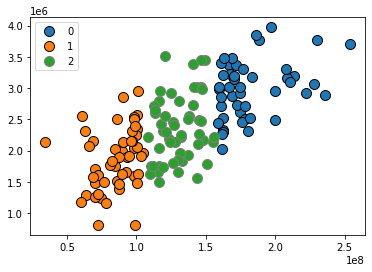

In [7]:
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline

mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
plt.legend()


In [8]:
from sklearn.cluster import KMeans
import numpy as np
ids = []
for i in range(5):
    if i == 0:
        ids.extend(list(combined[i]['id'].values))
        x = list(combined[i]['Team Payroll'].astype(float).values)
        y = list(combined[i]['TOTAL'].astype(float).values)
    else:
        ids.extend(list(combined[i]['id'].values))
        x.extend(list(combined[i]['Team Payroll'].astype(float).values))
        y.extend(list(combined[i]['TOTAL'].astype(float).values))
        
vals = pd.DataFrame({'payroll':x,'teamId':ids,'attendance':y})
means = vals.groupby('teamId').mean()


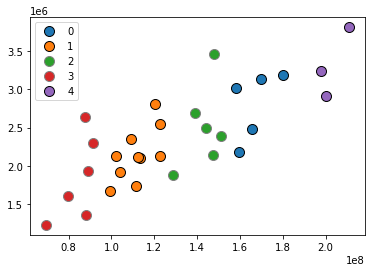

In [9]:
kmeans = KMeans(n_clusters=5)
X = means[['payroll','attendance']].values
kmeans.fit(X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
plt.legend()

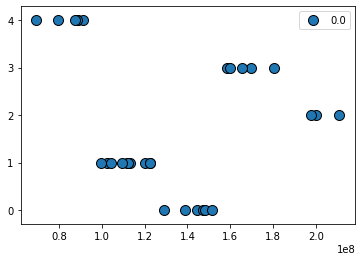

In [10]:
#Cluster on payroll
kmeans = KMeans(n_clusters=5)
X = means[['payroll']].values
kmeans.fit(X)
mglearn.discrete_scatter(X, kmeans.labels_, markers='o')
plt.legend()

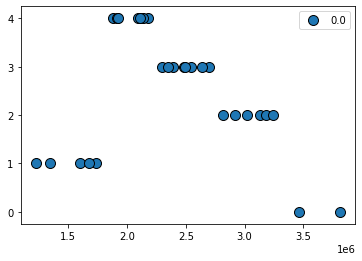

In [11]:
#Cluster on attendance
kmeans = KMeans(n_clusters=5)
X = means[['attendance']].values
kmeans.fit(X)
mglearn.discrete_scatter(X, kmeans.labels_, markers='o')
plt.legend()